# Introduction

- This project and the relevant data are hosted on GitHub: https://github.com/alexjmanlove/UDA_CW4
- This notebook is arranged to loosely follow the flow of content in the written pdf report. 
- Please review the cells and outputs before running the notebook yourself, as the outputs generated will be slightly different every time due to the stochastic nature of these algorithms.

- **Please be aware** that the training of the models was very computationally expensive. Over half an hour of compute time on NVIDIA A100 GPU, was required to train all the VAE models. On CPU the training may take several hours. As such the trained VAE models have been uploaded to OneDrive so that they can optionally be downloaded and placed in the same directory as this file for easy import and evaluation in Chapter 2, rather than training all from scratch. Link to trained VAE models: https://imperiallondon-my.sharepoint.com/:f:/g/personal/ajm421_ic_ac_uk/Es5rhKZFMEJJlUFezmWTMjkBce-WCl0Wq4Mhpuq2K4MMFg?e=eLeJ70

# 0) Packages and Loading the Data

## 0.1) Install and Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.cluster import KMeans

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(0)

d:\Users\alexa\anaconda3\envs\cuda_vision_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 0.2) Reading Reformatted `data.parquet` from Local Disk

In [2]:
data = pd.read_parquet("data.parquet")

# fix pixels datatype str -> 48x48 np.ndarray
data.pixels = data.pixels.apply(lambda L: np.array(L.split(' '), dtype="float32").reshape(48,48))

# 1) Chapter 1 Code

## (Not Included) Peek at the Data

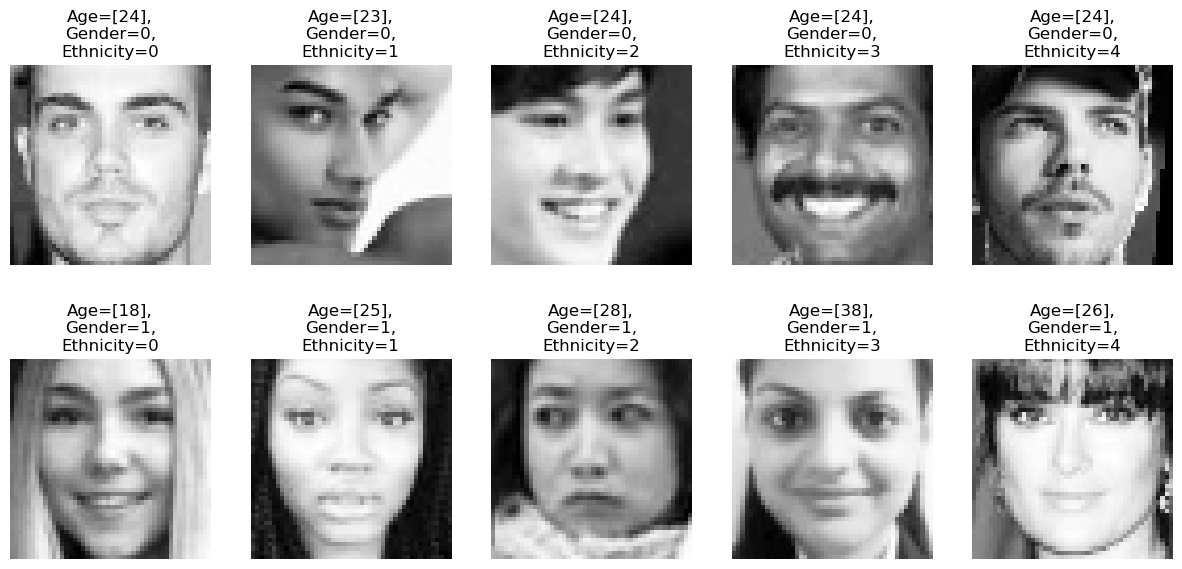

In [3]:
# plot of one observation per gender-ethnicity class.

f, axs = plt.subplots(2, 5, figsize=(15,7), sharex=True, sharey=True)

for gender in sorted(data.gender.unique()):
    for ethnicity in sorted(data.ethnicity.unique()):
        person = data.query('age>16').query('age<45')\
                     .query(f'gender=={gender}')\
                     .query(f'ethnicity=={ethnicity}')\
                     .sample()
        axs[gender,ethnicity].imshow(person.pixels.values[0], cmap = 'Greys_r')
        axs[gender,ethnicity].set_title(f"Age={person.age.values},\nGender={gender},\nEthnicity={ethnicity}")
        axs[gender,ethnicity].axis('off')

plt.show()

## (From Section 1.2) Plots of Sample Mean Faces

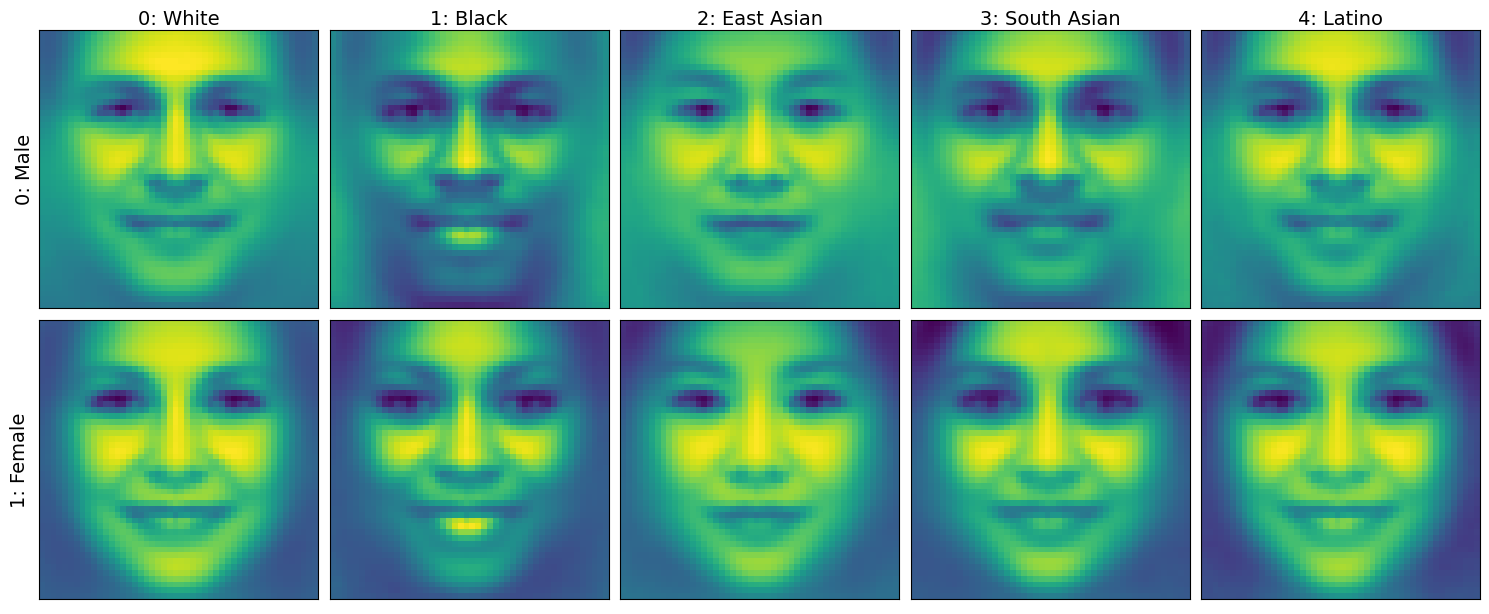

In [4]:
# Plot Grid of Average faces
f, axs = plt.subplots(2, 5, figsize=(15,7), sharex=True, sharey=True)
for gender in sorted(data.gender.unique()):
    for ethnicity in sorted(data.ethnicity.unique()):
        segment = data.query(f'gender=={gender}')\
                      .query(f'ethnicity=={ethnicity}')
        axs[gender,ethnicity].imshow(np.mean(np.stack(segment.pixels), axis=0))


# label grid rows and columns
for col, eth in enumerate(["White","Black","East Asian","South Asian","Latino"]):
    axs[0,col].set_xlabel(f"{col}: {eth}", fontsize=14)
    axs[0,col].xaxis.set_label_position('top') 

for row, gen in enumerate(["Male","Female"]):
    axs[row,0].set_ylabel(f"{row}: {gen}", fontsize=14)


# aesthetics
axs[0,0].yaxis.set_ticks_position('none') 
axs[0,0].xaxis.set_ticks_position('none') 
axs[0,0].set_yticks([])
axs[0,0].set_xticks([])
plt.tight_layout(h_pad=-3.5, w_pad=0.5)


plt.show()

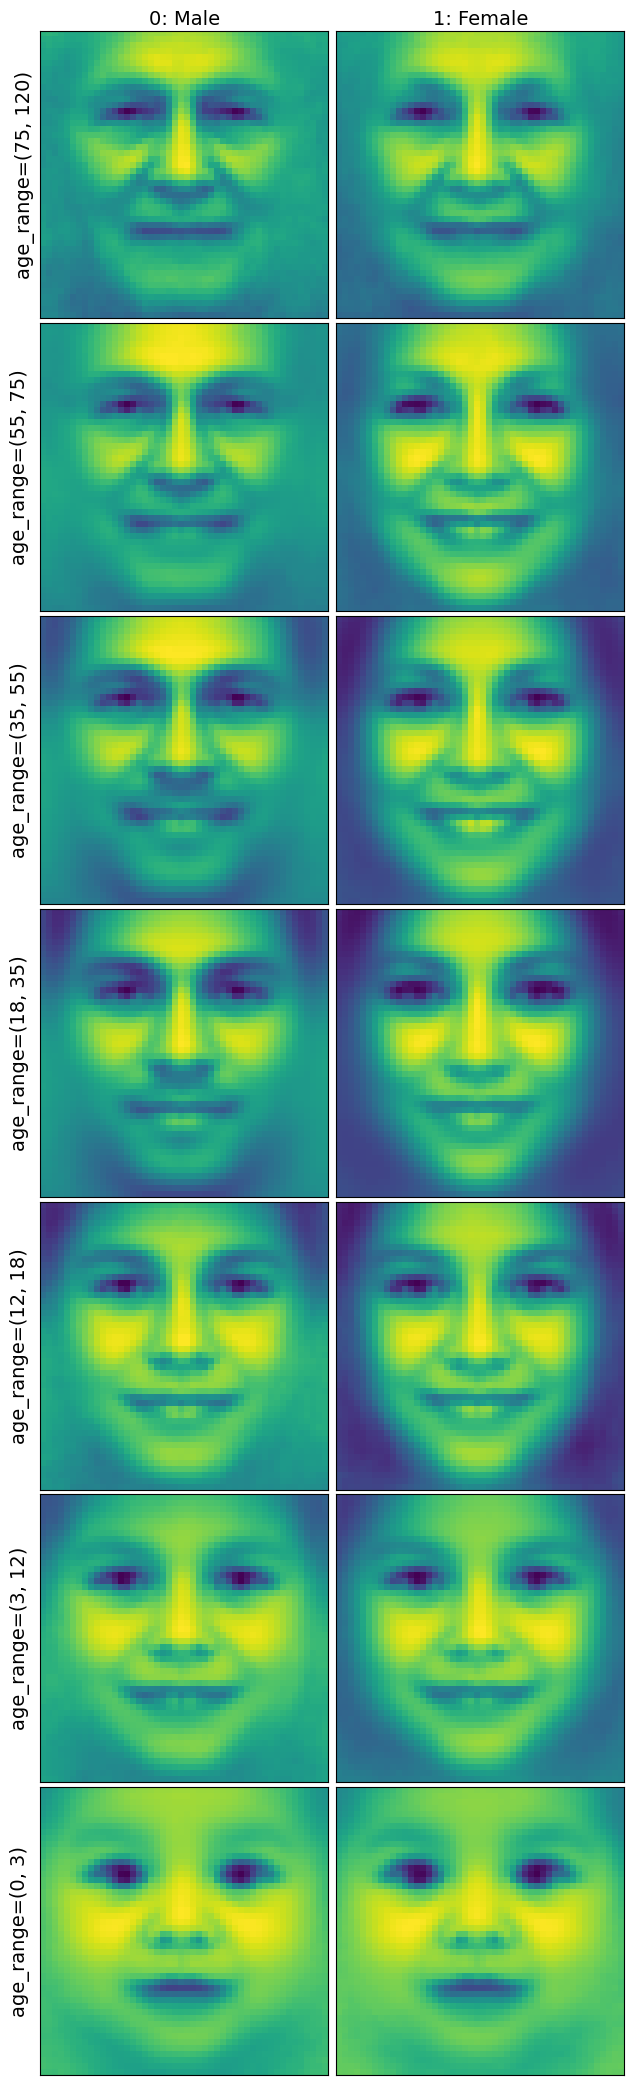

In [5]:
# Segmenting by Gender and Age Range

age_segments = [(0,3), (3,12), (12,18), (18,35), (35,55), (55,75), (75,120)][::-1]

f, axs = plt.subplots(len(age_segments), 2, figsize=(7,3*len(age_segments)), sharex=True, sharey=True)

for i,age_range in enumerate(age_segments):
    for j, gender in enumerate(["Male","Female"]):
        segment = data.query(f'age>{age_range[0]}')\
                    .query(f'age<{age_range[1]}')\
                    .query(f'gender=={j}')
        axs[i,j].imshow(np.mean(np.stack(segment.pixels), axis=0))


# label grid rows and columns
for row, age_range in enumerate(age_segments):
    axs[row,0].set_ylabel(f"{age_range=}", fontsize=14)
for col, gen in enumerate(["Male","Female"]):
    axs[0,col].set_xlabel(f"{col}: {gen}", fontsize=14)
    axs[0,col].xaxis.set_label_position('top') 

# aesthetics
axs[0,0].yaxis.set_ticks_position('none') 
axs[0,0].xaxis.set_ticks_position('none') 
axs[0,0].set_yticks([])
axs[0,0].set_xticks([])
plt.tight_layout(h_pad=0, w_pad=-2)

plt.show()

## (From Section 1.2) Exploratory Analysis of Target Variables

<AxesSubplot:xlabel='age', ylabel='Count'>

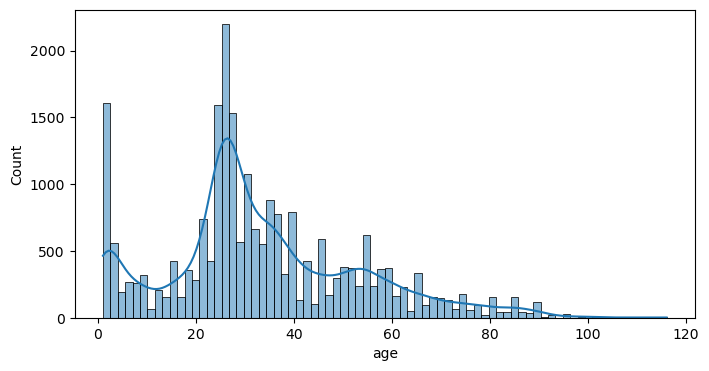

In [6]:
# Unused histogram and KDE of 'Age'
plt.figure(figsize=(8,4))
sns.histplot(data=data, x="age", kde=True)

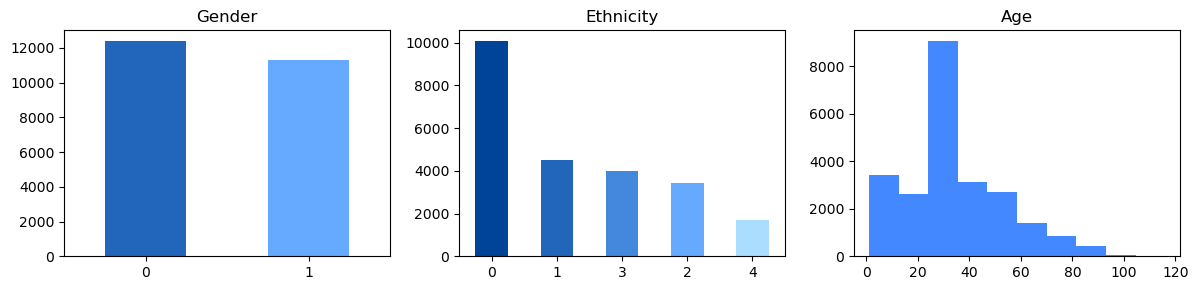

In [7]:
plt.subplots(1,3,figsize=(12,3))

plt.subplot(1, 3, 1)
data.gender.value_counts().plot(kind="bar", title="Gender", 
                                color=["#2266BB","#66AAFF"])
plt.xticks(rotation=0)

plt.subplot(1, 3, 2)
data.ethnicity.value_counts().plot(kind="bar", title="Ethnicity", 
                                   color=["#004499", 
                                          "#2266BB", 
                                          "#4488DD", 
                                          "#66AAFF", 
                                          "#AADDFF"])
plt.xticks(rotation=0)

plt.subplot(1, 3, 3)
data.age.hist(color="#4488FF")
plt.title("Age")

plt.tight_layout()
plt.grid(None)

## Defining PyTorch Dataset Class and DataLoaders

In [6]:
class FacesDataset(Dataset):
    def __init__(self, age_labels, ethnicity_labels, gender_labels, faces):
        self.age_labels = age_labels
        self.ethnicity_labels = ethnicity_labels
        self.gender_labels = gender_labels
        self.faces = faces

    def __len__(self):
        return len(self.ethnicity_labels)

    def __getitem__(self, index):
        label = {
                 'age':self.age_labels[index],
                 'eth':self.ethnicity_labels[index],
                 'gen':self.gender_labels[index]
                }

        image = transforms.ToTensor()(self.faces[index])

        return image, label

In [7]:
faces_dataset = FacesDataset(age_labels = data.age.values,
                          ethnicity_labels = data.ethnicity.values,
                          gender_labels = data.gender.values,
                          faces = data.pixels.values)

# 70%/20%/10%  train/validation/test  split 
train_size = int(len(faces_dataset) * 4/5)
test_size = len(faces_dataset) - train_size
train_set, validation_set, test_set,  = random_split(faces_dataset, [.7, .2, .1])

batch_size = 50

# Dataloaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

## (From Section 1.3) Define CNN Architectures


In [8]:
# To avoid repeating ourselves, we can implement an abstract class.
#  This abstract class contains the feature extraction architecture
#  and a utility function for plotting the outputs at each of the three 
#  convolutional layers.
class AbstractCNN(nn.Module):
    def __init__(self):
        super(AbstractCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(256)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 6 * 6, 1024),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024)
        ) 
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512)
        ) 

    def plot_convolutions(self, images):
        images = images.to(device)
        conv1_out = self.conv1(images)
        conv2_out = self.conv2(conv1_out)
        conv3_out = self.conv3(conv2_out)
        conv_outs = [conv1_out.cpu().detach().numpy(),
                     conv2_out.cpu().detach().numpy(),
                     conv3_out.cpu().detach().numpy()]

        # Plot square grids of convolution outputs at each layer
        # (this code assumes all channels have depth equal to a square number)
        for conv_out in conv_outs:
            dim = int(np.sqrt(conv_out.shape[1]))
            fig, axes = plt.subplots(figsize=(8,8),
                                     nrows=dim, ncols=dim, 
                                     sharey=True, sharex=True)
            for i in range(dim):
                for j in range(dim):
                    axes[i,j].imshow(conv_out[0, (dim*i+j), :, :])
                    axes[i,j].axis('off') 
            fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
            
            plt.show()

In [9]:
class GenderClassifier(AbstractCNN):
    def __init__(self):
        super(GenderClassifier, self).__init__()
        self.fc4 = nn.Sequential(
            nn.Linear(512, 2),
            nn.LeakyReLU()
        ) 
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = F.softmax(x, dim=1)
        return x

In [10]:
class EthnicityClassifier(AbstractCNN):
    def __init__(self):
        super(EthnicityClassifier, self).__init__()
        self.fc4 = nn.Sequential(
            nn.Linear(512, 5),
            nn.LeakyReLU()
        ) 
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)        
        x = F.softmax(x, dim=1)
        return x

In [11]:
class AgeRegressor(AbstractCNN):
    def __init__(self):
        super(AgeRegressor, self).__init__()
        self.float()
        self.fc4 = nn.Sequential(
            nn.Linear(512, 1)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

## (From Figure 1.6) Convolution Output Visualisations

This can take up to five minutes.

d:\Users\alexa\anaconda3\envs\cuda_vision_env\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


TypeError: Invalid shape (1, 48, 48) for image data

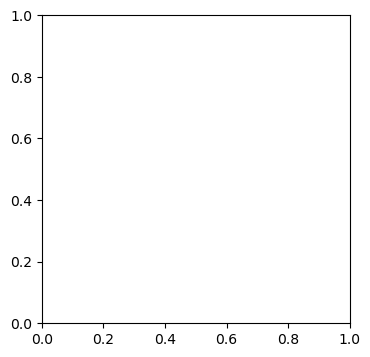

In [26]:
# my face 
from PIL import Image
my_face_image = np.asarray(Image.open('myface/smallface.png').convert('L')) / 255.0
my_face_image = torch.Tensor(my_face_image).to(device)

test_model = EthnicityClassifier().to(device)

plt.figure(figsize=(4,4))
plt.imshow(my_face_image.cpu(), cmap="Greys_r")
plt.axis('off')
plt.show()

test_model.plot_convolutions(my_face_image)

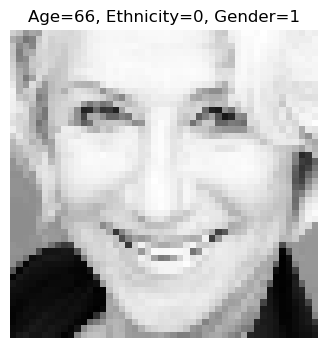

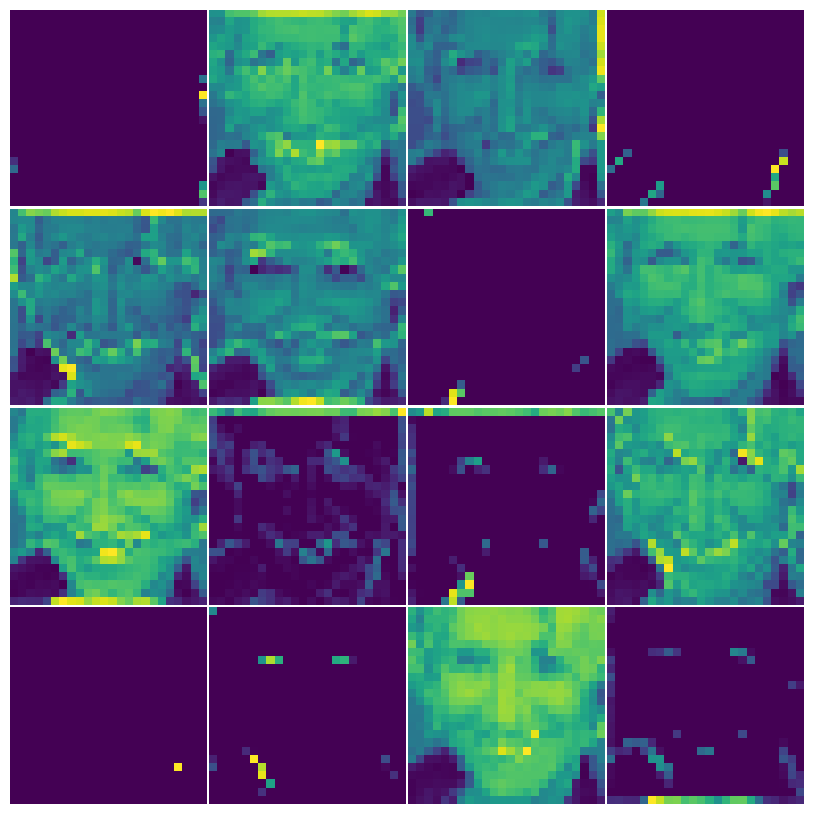

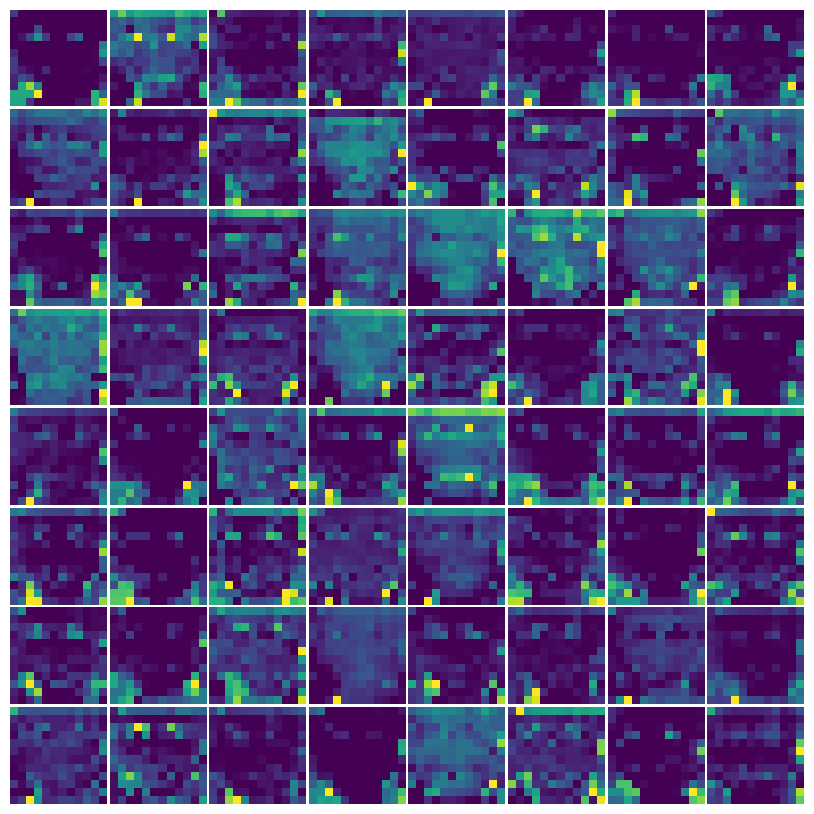

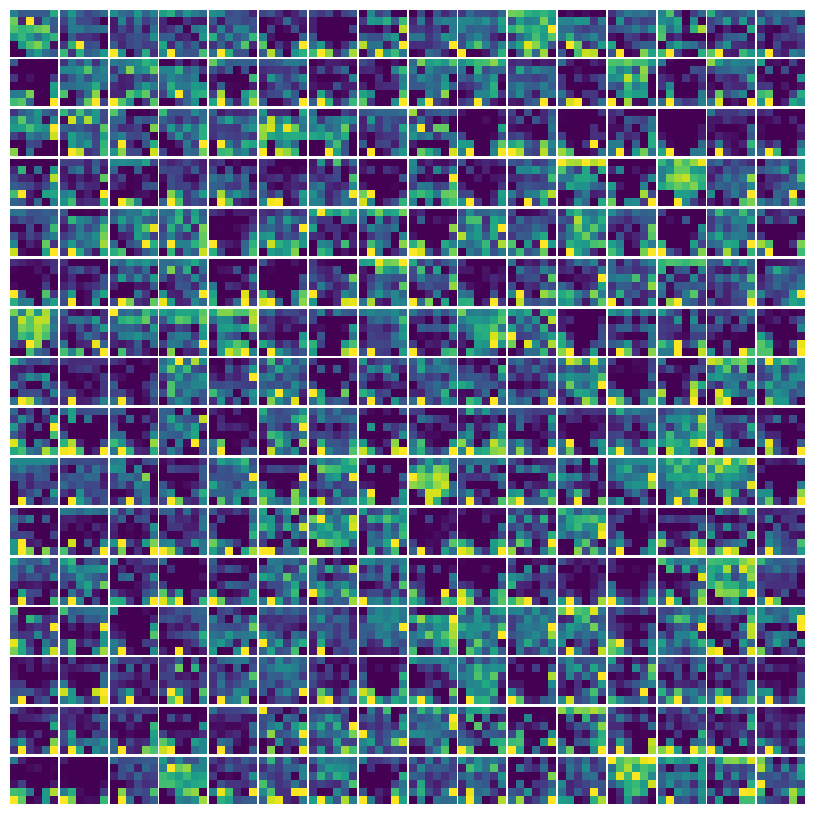

In [15]:
imgs, labs = next(iter(train_loader))

imgs = imgs.to(device)

test_model = EthnicityClassifier().to(device)

plt.figure(figsize=(4,4))
plt.title(f"Age={labs['age'][0].to(device)}, Ethnicity={labs['eth'][0].to(device)}, Gender={labs['gen'][0].to(device)}")
plt.imshow(imgs[0][0].cpu(), cmap="Greys_r")
plt.axis('off')
plt.show()

test_model.plot_convolutions(imgs)

## (From Section 1.3.3) Instantiating and Training Supervised Models

In [16]:
# ensure consistent weight initialisation.
torch.manual_seed(0)
gen_model = GenderClassifier().to(device)
torch.manual_seed(0)
eth_model = EthnicityClassifier().to(device)
torch.manual_seed(0)
age_model = AgeRegressor().to(device)

In [ ]:
# record training losses for later analysis 
gen_losses = list()
eth_losses = list()
age_losses = list()
total_step = len(train_loader)

# record performance on validation set at each epoch
gen_epoch_valid_accuracy = list()
eth_epoch_valid_accuracy = list()
age_epoch_valid_accuracy = list()

# loss functions
ce_loss = torch.nn.CrossEntropyLoss()
l2_loss = torch.nn.MSELoss()

# hyperparam tuning
num_epochs = 10
lr_schedule_function = lambda epoch: 0.0005/(1+epoch)


# Training Epochs
for epoch in range(num_epochs):

    # Adjust Learning Rates 
    new_lr = lr_schedule_function(epoch)
    gen_optimizer = torch.optim.Adam(gen_model.parameters(), lr=new_lr)
    eth_optimizer = torch.optim.Adam(eth_model.parameters(), lr=new_lr)
    age_optimizer = torch.optim.Adam(age_model.parameters(), lr=new_lr)
    print(f"Starting Epoch {epoch+1} with learning rate {new_lr}.")

    # Loop over batches
    for i, (images, labels) in enumerate(train_loader):

        # CUDA and fix shape, dtype of age labels.
        images = images.to(device)
        labels['gen'] = labels['gen'].to(device)
        labels['eth'] = labels['eth'].to(device)
        labels['age'] = labels['age'].to(torch.float).reshape(-1,1).to(device)

        # Zero the gradients
        gen_optimizer.zero_grad()
        eth_optimizer.zero_grad()
        age_optimizer.zero_grad()

        # Forward pass
        gen_outputs = gen_model(images)
        eth_outputs = eth_model(images)
        age_outputs = age_model(images)

        # Compute the losses
        gen_loss = ce_loss(gen_outputs, labels['gen'])
        eth_loss = ce_loss(eth_outputs, labels['eth'])
        age_loss = l2_loss(age_outputs, labels['age'])

        # Backward pass
        gen_loss.backward()
        eth_loss.backward()
        age_loss.backward()

        # Update the parameters
        gen_optimizer.step()
        eth_optimizer.step()
        age_optimizer.step()

        # record data
        gen_losses.append((epoch, gen_loss.cpu().item()))
        eth_losses.append((epoch, eth_loss.cpu().item()))
        age_losses.append((epoch, age_loss.cpu().item()))

        if (i+1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Step[{i+1}/{total_step}]: "+
                  f"GenLoss={gen_loss.item():.4f}, EthLoss={eth_loss.item():.4f} AgeLoss={age_loss.item():.4f}")

    # model evaluation after each epoch
    gen_model.eval()    
    eth_model.eval()    
    age_model.eval()    
    with torch.no_grad():
        gen_correct, eth_correct, age_L2_loss = 0, 0, 0
        total = 0
        for images, labels in validation_loader:
            images = images.to(device)
            labels['gen'] = labels['gen'].to(device)
            labels['eth'] = labels['eth'].to(device)
            labels['age'] = labels['age'].to(torch.float).reshape(-1,1).to(device)

            gen_outputs = gen_model(images)
            eth_outputs = eth_model(images)
            age_outputs = age_model(images)

            _,gen_predicted = torch.max(gen_outputs, 1)
            _,eth_predicted = torch.max(eth_outputs, 1)
            
            total += labels['gen'].size(0)
            gen_correct += (gen_predicted == labels['gen']).sum().item()
            eth_correct += (eth_predicted == labels['eth']).sum().item()
            age_L2_loss += l2_loss(age_outputs, labels['age']).detach().cpu().numpy()

        gen_test_accuracy = gen_correct/total
        eth_test_accuracy = eth_correct/total
        age_test_performance = age_L2_loss
        print(f"Test Performance: Gen={(100*gen_test_accuracy):.4f}%, "+
              f"Eth={(100*eth_test_accuracy):.4f}%,"+
              f"Age_L2={age_test_performance:.4f}")
        gen_epoch_valid_accuracy.append((epoch, gen_test_accuracy))
        eth_epoch_valid_accuracy.append((epoch, eth_test_accuracy))
        age_epoch_valid_accuracy.append((epoch, age_test_performance))
    
    # return to training mode
    gen_model.train()    
    eth_model.train()    
    age_model.train()   


gen_losses = pd.DataFrame(gen_losses, columns=["Epoch", "Loss"])
eth_losses = pd.DataFrame(eth_losses, columns=["Epoch", "Loss"])
age_losses = pd.DataFrame(age_losses, columns=["Epoch", "Loss"])

gen_epoch_valid_accuracy = pd.DataFrame(gen_epoch_valid_accuracy, columns=["Epoch", "Gen_Valid_Loss"])
eth_epoch_valid_accuracy = pd.DataFrame(eth_epoch_valid_accuracy, columns=["Epoch", "Eth_Valid_Loss"])
age_epoch_valid_accuracy = pd.DataFrame(age_epoch_valid_accuracy, columns=["Epoch", "Age_Valid_Loss"])

epoch_valid_accuracies = gen_epoch_valid_accuracy.merge(eth_epoch_valid_accuracy,on='Epoch').merge(age_epoch_valid_accuracy,on='Epoch')

Starting Epoch 1 with learning rate 0.0005.
Epoch 1/10, Step[50/332]: GenLoss=0.5248, EthLoss=1.4065 AgeLoss=1167.0571
Epoch 1/10, Step[100/332]: GenLoss=0.5163, EthLoss=1.2891 AgeLoss=975.1228
Epoch 1/10, Step[150/332]: GenLoss=0.4798, EthLoss=1.2639 AgeLoss=1435.2477
Epoch 1/10, Step[200/332]: GenLoss=0.4491, EthLoss=1.2277 AgeLoss=1043.5389
Epoch 1/10, Step[250/332]: GenLoss=0.4320, EthLoss=1.1471 AgeLoss=532.3661
Epoch 1/10, Step[300/332]: GenLoss=0.4624, EthLoss=1.1064 AgeLoss=475.2109
Test Performance: Gen=83.6743%, Eth=69.5845%,Age_L2=27513.7569
Starting Epoch 2 with learning rate 0.00025.
Epoch 2/10, Step[50/332]: GenLoss=0.4884, EthLoss=1.1976 AgeLoss=307.8257
Epoch 2/10, Step[100/332]: GenLoss=0.4469, EthLoss=1.1247 AgeLoss=185.4568
Epoch 2/10, Step[150/332]: GenLoss=0.4738, EthLoss=1.1875 AgeLoss=233.8390
Epoch 2/10, Step[200/332]: GenLoss=0.4474, EthLoss=1.1150 AgeLoss=181.3746
Epoch 2/10, Step[250/332]: GenLoss=0.4315, EthLoss=1.2317 AgeLoss=132.9188
Epoch 2/10, Step[300/3

## (From Fig 1.7, Fig 1.8) Plotting Training and Validation Loss

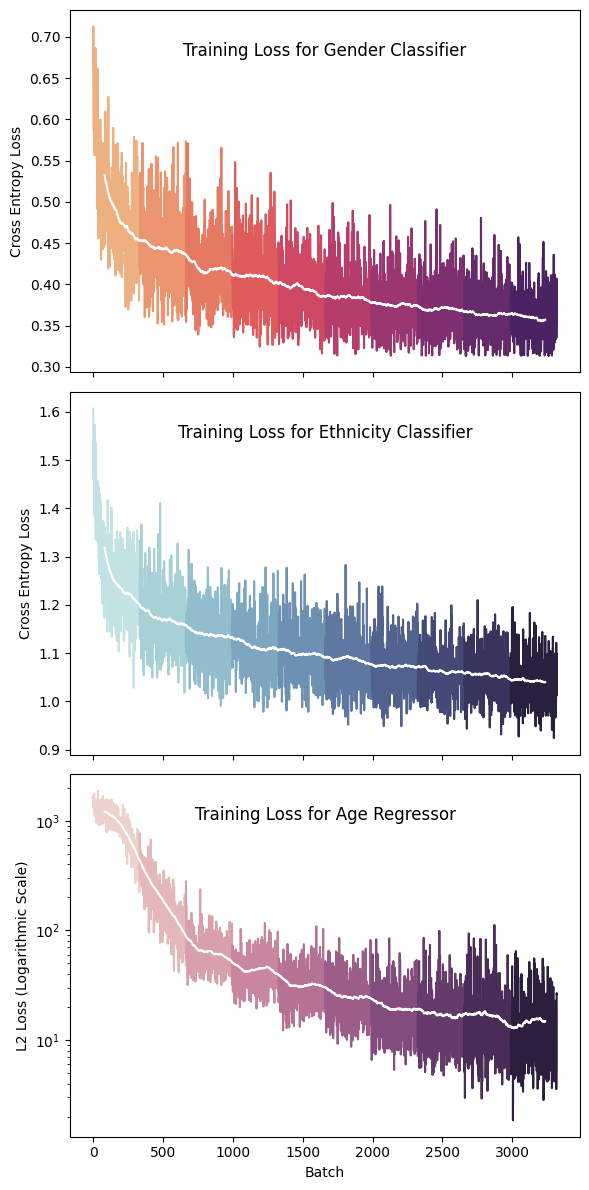

In [ ]:
# Plotting the Training Loss of Each Model

f, axs = plt.subplots(3, 1, figsize=(6,12), sharex=True)
plt.style.use('default')

styles = [
    'flare',
    sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True),
    sns.cubehelix_palette(as_cmap=True)
]

for i,(losses,name) in enumerate([(gen_losses, "Gender Classifier"), 
                           (eth_losses, "Ethnicity Classifier"), 
                           (age_losses, "Age Regressor")]):
    sns.lineplot(ax=axs[i], data=losses, y='Loss', x=losses.index, hue='Epoch', palette=styles[i], legend=False)
    axs[i].plot(losses.Loss.rolling(window=int(total_step/2)).mean()[int(total_step/4):].reset_index().Loss, color="white", alpha=1)
    axs[i].set_xlabel("Batch")
    axs[i].set_ylabel("L2 Loss (Logarithmic Scale)" if i==2 else "Cross Entropy Loss")
    axs[i].set_title(f"Training Loss for {name}", y=0.85)
    if i==2: 
        axs[i].set_yscale("log")

plt.tight_layout()

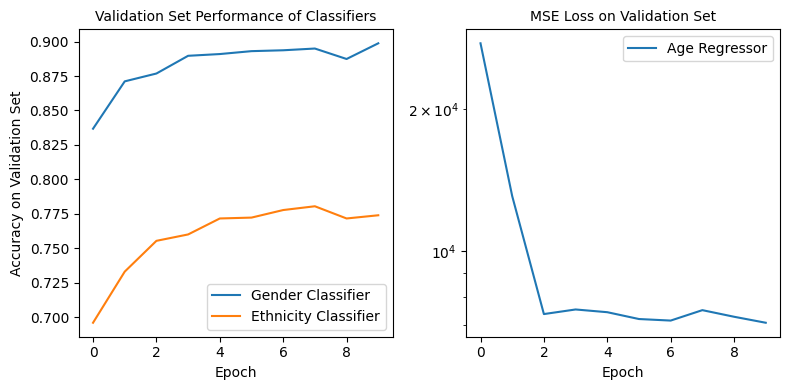

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(8,4))

# plot classifier accuracies 
for loss in epoch_valid_accuracies.columns[1:3]:
    ax[0].plot(epoch_valid_accuracies.Epoch, epoch_valid_accuracies[loss])
ax[0].set_title("Validation Set Performance of Classifiers", size=10)
ax[0].legend(['Gender Classifier','Ethnicity Classifier'], loc='lower right')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy on Validation Set")

ax[1].plot(epoch_valid_accuracies.Epoch, epoch_valid_accuracies['Age_Valid_Loss'])
ax[1].set_yscale("log")
ax[1].set_title("MSE Loss on Validation Set", size=10)
ax[1].legend(['Age Regressor'], loc='upper right')
ax[1].set_xlabel("Epoch")
plt.tight_layout(h_pad=2)


## (From Section 1.4) Final Evaluation on Test Set

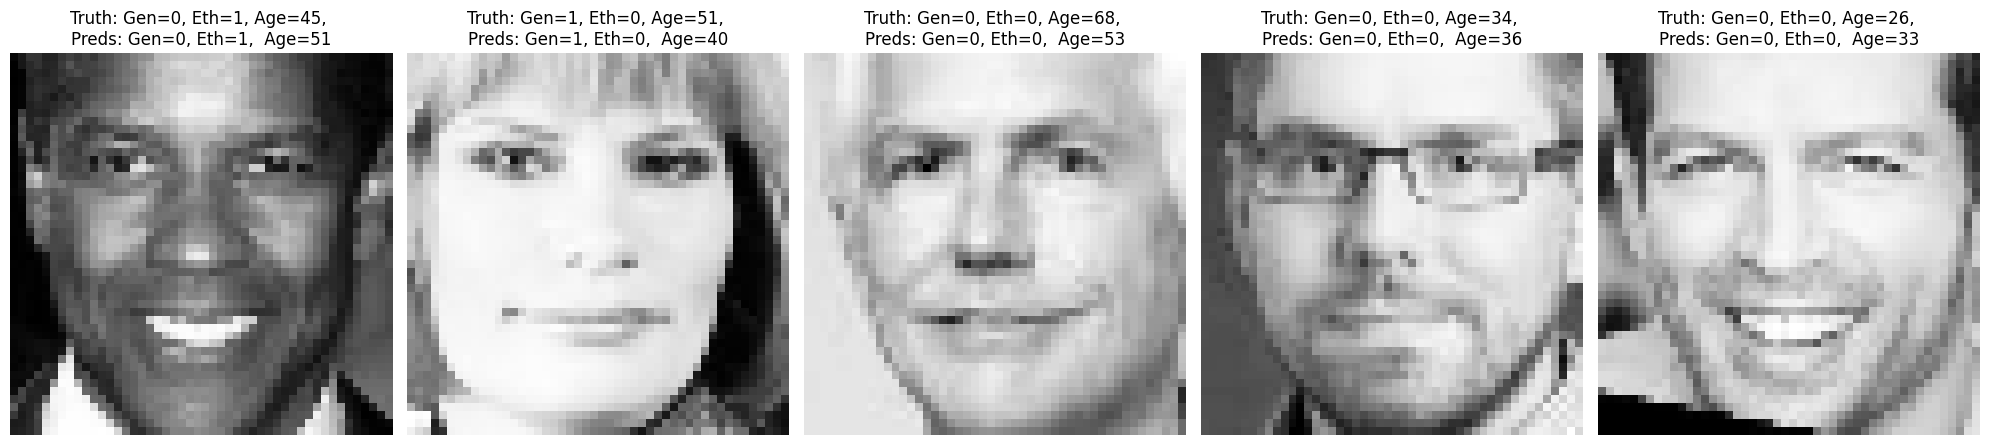

In [ ]:
gen_model.eval()
eth_model.eval()
age_model.eval()

fig, ax = plt.subplots(1, 5, figsize=(20,12))

with torch.no_grad():

    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels['gen'] = labels['gen'].to(device)
    labels['eth'] = labels['eth'].to(device)
    labels['age'] = labels['age'].to(torch.float).reshape(-1,1).to(device)

    for idx, pic in enumerate(np.array(images.cpu())[:5]):
        ax[idx].imshow(pic[0,:,:], cmap="Greys_r")

        pred_string = f"Truth: Gen={labels['gen'][idx]}, Eth={labels['eth'][idx]}, Age={int(labels['age'][idx].cpu().item())}, "+\
        f"\nPreds: Gen={np.argmax(gen_model(images[idx:(1+idx)]).cpu().detach())}, Eth={np.argmax(eth_model(images[idx:(1+idx)]).cpu().detach())},  Age={int(age_model(images[idx:(1+idx)]).cpu().detach().numpy()[0][0])}"

        ax[idx].set_title(pred_string)
        ax[idx].axis('off')

plt.tight_layout()

plt.show()

#### Confusion Matrices

In [ ]:
# Building Confusion Matrices

from sklearn.metrics import confusion_matrix

gen_preds = list()
gen_truth = list()

eth_preds = list()
eth_truth = list()

# iterate over test data
for images, labels in test_loader:
        images = images.to(device)
        gen_output = gen_model(images)
        eth_output = eth_model(images)
        gen_output = torch.argmax(gen_output, 1).cpu().numpy()
        eth_output = torch.argmax(eth_output, 1).cpu().numpy()
        gen_preds.extend(gen_output)
        eth_preds.extend(eth_output)
        gen_truth.extend(labels['gen']) 
        eth_truth.extend(labels['eth']) 

gen_classes = ['Male', 'Female']
eth_classes = ['White','Black','East Asian','South Asian','Latino']

# Build confusion matrix
gen_conf_matrix = confusion_matrix(gen_truth, gen_preds)
eth_conf_matrix = confusion_matrix(eth_truth, eth_preds)

df_gen_cm = pd.DataFrame(gen_conf_matrix/sum(gen_conf_matrix), 
                         index = [c for c in gen_classes],
                         columns = [c for c in gen_classes])
df_eth_cm = pd.DataFrame(eth_conf_matrix/sum(eth_conf_matrix), 
                         index = [c for c in eth_classes],
                         columns = [c for c in eth_classes])

In [ ]:
# Plotting Confusion Matrices

fig, ax = plt.subplots(1,2,figsize = (10,4), gridspec_kw={'width_ratios':[3,5]})
sns.heatmap(ax=ax[0], data=df_gen_cm, annot=True, cbar=False, vmin=0, vmax=1)
ax[0].set_ylabel('Prediction',size=14)
ax[0].set_xlabel('Truth', size=14)
ax[0].xaxis.set_label_position('top')

sns.heatmap(ax=ax[1], data=df_eth_cm, annot=True, vmin=0, vmax=1)
ax[1].set_xlabel('Truth', size=14)
ax[1].xaxis.set_label_position('top')
ax[1].set_xticklabels(eth_classes, rotation=15)


plt.tight_layout()

#### Precision, Recall and F1 Matrices

In [ ]:
# Precision and Recall Metrics
gen_tp = np.diag(gen_conf_matrix)
gen_fp = np.sum(gen_conf_matrix, axis=0) - gen_tp
gen_fn = np.sum(gen_conf_matrix, axis=1) - gen_tp
gen_recall = gen_tp / (gen_tp+gen_fp)
gen_precision = gen_tp / (gen_tp+gen_fn)
gen_f1 = gen_tp/(gen_tp+0.5*(gen_fp+gen_fn))

eth_tp = np.diag(eth_conf_matrix)
eth_fp = np.sum(eth_conf_matrix, axis=0) - eth_tp
eth_fn = np.sum(eth_conf_matrix, axis=1) - eth_tp
eth_recall = eth_tp / (eth_tp+eth_fp)
eth_precision = eth_tp / (eth_tp+eth_fn)
eth_f1 = eth_tp/(eth_tp+0.5*(eth_fp+eth_fn))

In [ ]:
# Plotting Precision and Recall 

fig, ax = plt.subplots(1,2, figsize = (10,4), gridspec_kw={'width_ratios':[2,5]}, sharey=True)
sns.heatmap(ax=ax[0], annot=True, cmap="crest", vmin=0, vmax=1, cbar=False,
            data=pd.DataFrame(np.c_[gen_precision, gen_recall, gen_f1].T,
                              columns=gen_classes, index=["Precision","Recall","F1 Score"]))
ax[0].set_title("Gender Classifier")

sns.heatmap(ax=ax[1], annot=True, cmap="crest", vmin=0, vmax=1,
            data=pd.DataFrame(np.c_[eth_precision, eth_recall, eth_f1].T,
                              columns=eth_classes, index=["Precision","Recall","F1 Score"]))
ax[1].set_title("Ethnicity Classifier")

plt.tight_layout()

#### Age Regressor Test Set Performance

In [ ]:
# Calculating MSE and MAE of Age Regressor on the Test Set
age_predictions = []
age_targets = []

for images, labels in test_loader:
    images = images.to(device)
    labels['age'] = labels['age'].to(torch.float).reshape(-1,1).to(device)
    age_output = age_model(images)
    age_predictions.extend(age_output.cpu().detach().numpy())
    age_targets.extend(labels['age'].cpu())

# Calculate the mean squared error and mean absolute error
mse = torch.nn.MSELoss()(torch.tensor(age_predictions), 
                         torch.tensor(age_targets).unsqueeze(-1))
mae = torch.nn.L1Loss()(torch.tensor(age_predictions),
                        torch.tensor(age_targets).unsqueeze(-1))

# Print the results
print("Mean Squared Error:", mse.item())
print("Mean Absolute Error:", mae.item())

Mean Squared Error: 78.88895416259766
Mean Absolute Error: 6.307634353637695


<ipython-input-380-690f600322d4>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  mse = torch.nn.MSELoss()(torch.tensor(age_predictions),


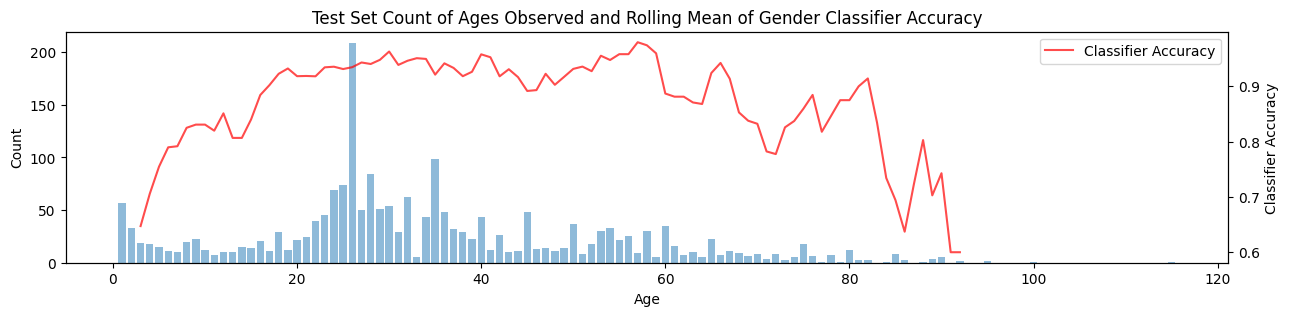

In [ ]:
# gender classifier performance segmented by age
gen_predictions = []
true_gens = []
true_ages = []

for images, labels in test_loader:
    images = images.to(device)
    labels['age'] = labels['age'].to(torch.float).reshape(-1,1).to(device)
    gen_output = gen_model(images)
    gen_predictions.extend(gen_output.cpu().detach().numpy())
    true_gens.extend(labels['gen'].cpu())
    true_ages.extend(labels['age'].cpu())

gen_predictions = np.argmax(np.array(gen_predictions), axis=1)
true_gens = np.array(true_gens)
true_ages = np.array(torch.tensor(true_ages))

results = pd.DataFrame(np.c_[gen_predictions, true_gens, true_ages], columns=["Preds", "Truth", "Age"])
results['correct'] = (results.Preds == results.Truth)

fig,ax=plt.subplots(figsize=(15,3))
ax.bar(height=results.groupby('Age').sum().correct, x=results.groupby('Age').sum().correct.index, alpha=0.5)

# (results.groupby('Age').sum().correct/results.groupby('Age').count().Preds).rolling(5).mean()[4:].reset_index()[0].plot(secondary_y=True, alpha=0.6, color="r")
ax2 = ax.twinx()

ax2.plot((results.groupby('Age').sum().correct/results.groupby('Age').count().Preds).rolling(5).mean()[2:].reset_index()[0], color="r", alpha=0.7)

ax2.set_ylabel('Classifier Accuracy')

ax.set_ylabel("Count")
ax.set_xlabel("Age")

plt.legend(['Classifier Accuracy'])

plt.title("Test Set Count of Ages Observed and Rolling Mean of Gender Classifier Accuracy")
plt.show()

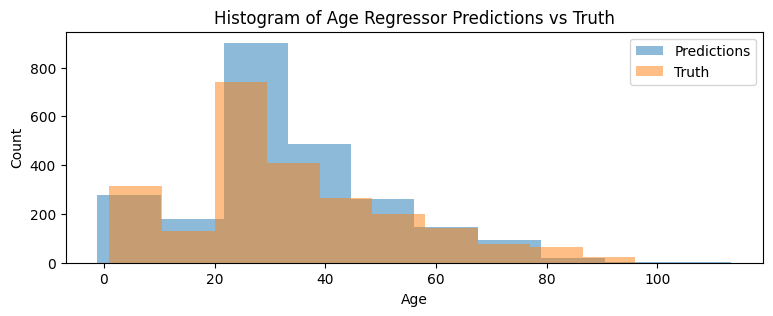

In [ ]:
# Histograms of Age Predictions vs Ground Truth

plt.figure(figsize=(9,3))
plt.hist(np.array(age_predictions).flatten(), alpha=0.5)
plt.hist(np.array([a.item() for a in age_targets]), alpha=0.5)
plt.legend(['Predictions','Truth'])
plt.title("Histogram of Age Regressor Predictions vs Truth")
plt.ylabel("Count")
plt.xlabel('Age')
plt.show()

# 2) Chapter 2 Code 

## Reducing Batch Size to Decrease Compute Requirements

In [9]:
batch_size = 10

# Dataloaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

## (From Section 2.1) Autoencoder

The analysis in this section was ultimately left out of the report due to page limit, however it is necessary to run the first cell defining the Autoencoder classes because I have written the later VAE classes to inherit from these.

## Autoencoder Classes

These are used as parent classes for the VAE later.

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(128)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(512)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512*6*6, 2048),
            nn.LeakyReLU(),
            nn.BatchNorm1d(2048)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024)
        ) 
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512)
        ) 
        self.fc4 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512)
        ) 
        self.fc2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024)
        ) 
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.LeakyReLU(),
            nn.BatchNorm1d(2048)
        ) 
        self.fc4 = nn.Sequential(
            nn.Linear(2048, 512 * 6 * 6),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512 * 6 * 6)
        )
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(128, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc1(z)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = x.view(-1, 512, 6, 6)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### (Unincluded) Autoencoder Training 

In [ ]:
# torchinfo.summary(Autoencoder(), input_size=(batch_size, 1, 48, 48))

In [ ]:
# # Training loop
# autoencoder_model = Autoencoder().to(device)
# autoencoder_model.train()
    
# num_epochs = 100
# lr_schedule_function = lambda epoch: 0.0005/(1+epoch)

# try:
#     for epoch in range(num_epochs):

#         new_lr = lr_schedule_function(epoch%50) # reset schedule after 25 epochs
#         print(f'Starting New Epoch with learning_rate={new_lr}')
#         optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=new_lr)

#         for i, (x, _) in enumerate(train_loader):
#             x = x.float().to(device)/255

#             optimizer.zero_grad()
#             output = autoencoder_model(x)
#             loss = F.binary_cross_entropy(output.reshape(-1, 1), 
#                                           x.reshape(-1, 1), 
#                                           reduction="sum")
#             loss.backward()
#             optimizer.step()

#             if (i+1) % 500 == 0:
#                 print(f"Epoch {epoch+1}/{num_epochs}, Step[{i+1}/{len(train_loader)}]: {loss.item()}")
        
        
# except:
#     print('Error')

In [ ]:
# compressed_data = [] # X_1, X_2, gender, ethnicity, age

# with torch.no_grad():
#     for x, labels in validation_loader:
#         x = x.float().to(device)

#         if x.shape[0] < batch_size:
#             continue

# #         # output = autoencoder_model(x)
# #         # fig,ax=plt.subplots(2,1,sharey=True)
# #         # ax[0].imshow(x[0,0].cpu().detach().numpy())
# #         # ax[0].axis('off')
# #         # ax[1].imshow(output[0,0].cpu().detach().numpy())
# #         # ax[1].axis('off')
# #         # plt.tight_layout()
# #         # plt.show()
        
#         out = np.c_[autoencoder_model.encoder(x).cpu().detach().numpy(), np.zeros((batch_size,3))]
#         out[:,2] = labels['gen'].numpy()
#         out[:,3] = labels['eth'].numpy()
#         out[:,4] = labels['age'].numpy()

#         autoencoder_model.encoder(x).cpu().detach().numpy()

#         compressed_data.append(out)

# compressed_data = pd.DataFrame(np.concatenate(compressed_data), 
#                                columns=["Z_1","Z_2","Gender","Ethnicity","Age"])

Text(0, 0.5, 'Z_2')

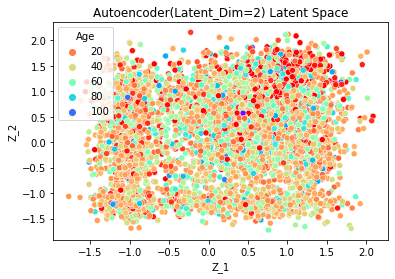

In [ ]:
# # rainbow_r for age, default for others.

# # torch.save(autoencoder_model, 'autoencoder_dim_2.pt')
# sns.scatterplot(data=compressed_data, x='Z_1', y='Z_2', hue='Age', palette='rainbow_r')
# plt.title('Autoencoder(Latent_Dim=2) Latent Space')
# plt.xlabel('Z_1')
# plt.ylabel('Z_2')

## (From Section 2.2.1) Variational Autoencoder

In [11]:
class VAE_Encoder(Encoder):
    def __init__(self, latent_dim):
        super(VAE_Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc_mu = nn.Sequential(
            nn.Linear(512, latent_dim),
            nn.LeakyReLU()
        )
        self.fc_logvar = nn.Sequential(
            nn.Linear(512, latent_dim),
            nn.LeakyReLU()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


class VAE_Decoder(Decoder):
    def __init__(self, latent_dim):
        super(VAE_Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc1 = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512)
        ) 

    def forward(self, z):
        x = self.fc1(z)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = x.view(-1, 512, 6, 6)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        return x
		
		
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = VAE_Encoder(latent_dim)
        self.decoder = VAE_Decoder(latent_dim)

    def reparametrisation(self, mu, logvar):
        std = torch.exp(0.5*logvar) # exponentiate and sqrt logvar to get std
        err = torch.randn_like(std) # # randn_like samples standard normal
        z = err.mul(std).add_(mu)
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparametrisation(mu, logvar)
        return self.decoder(z), z, mu, logvar


def loss_fn(recon_x, x, mu, logvar, beta):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    BCE = F.binary_cross_entropy(recon_x.reshape(-1, 1), x.reshape(-1, 1), reduction="sum")
    return BCE + beta*KLD, KLD.item() # + KLD?

## (From Section 2.2.1) VAE Training

This cell takes a long time to train. The full model is very large with nearly 100 million parameters.

In [ ]:
# Model Initialisation and Training Loop
VAE_model = VAE(latent_dim=256).to(device)

# beta-VAE regularisation scaling hyperparameter
beta = 0.01

#training
num_epochs = 200
lr_schedule_function = lambda epoch: 0.0005/(1+epoch)

for epoch in range(num_epochs):

    new_lr = lr_schedule_function(epoch%50) # reset schedule on 50 epoch cycle (maybe helps?)
    print(f'Starting New Epoch with learning_rate={new_lr}')
    VAE_optimizer = torch.optim.Adam(VAE_model.parameters(), lr=new_lr)
    
    VAE_model.train()
    for i, (x, _) in enumerate(train_loader):
        x = x.float().to(device)/255

        VAE_optimizer.zero_grad()
        recon_x, z, mu, logvar = VAE_model(x)
        VAE_loss, KLD = loss_fn(recon_x, x, mu, logvar, beta)

        VAE_loss.backward()
        VAE_optimizer.step()

        if (i+1) % 300 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Step[{i+1}/{len(train_loader)}]: {VAE_loss.item()}, {KLD=}")

In [ ]:
# Persist the model to disk.
# torch.save(VAE_model.state_dict(), 'VAE_model_dim_256_beta_001.pt')

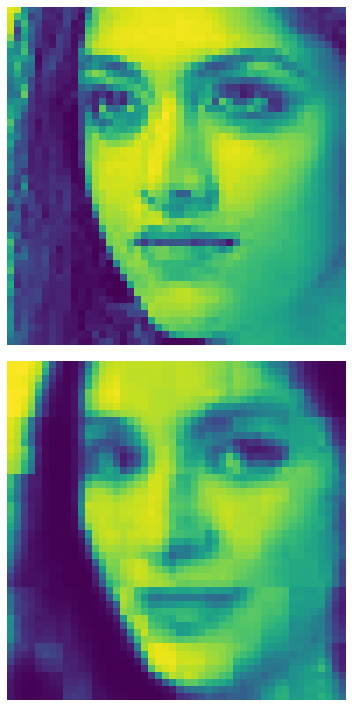

In [ ]:
# Model Evaluation
VAE_model.eval()

with torch.no_grad():
    for i, (x, _) in enumerate(test_loader):
        x = x.float().to(device)
        recon_x, z, mu, logvar  = VAE_model(x)

        fig,ax = plt.subplots(2,1,sharex=True, figsize=(5,10))
        ax[0].imshow(x[0,0].cpu().detach().numpy())
        ax[0].axis('off')
        
        ax[1].imshow(recon_x[0,0].cpu().detach().numpy())
        ax[1].axis('off')
        
        plt.tight_layout()
        # plt.savefig(f'VAE_dim_4_no_beta_Outputs/combined_{i}.png')
        
        # if i==200:
        break

## (From Section 2.2.2) Comparing The 4 VAEs

Here the models were trained, saved to local disk and later read in to the notebook. This was a more sensible approach than training the four model from scratch every time.

In [ ]:
VAE_dim_4_no_beta = VAE(latent_dim=4).to(device)
VAE_dim_4_beta_001 = VAE(latent_dim=4).to(device)
VAE_dim_256_no_beta = VAE(latent_dim=256).to(device)
VAE_dim_256_beta_001 = VAE(latent_dim=256).to(device)

VAE_dim_4_no_beta.load_state_dict(torch.load('VAE_model_dim_4_no_beta.pt'))
VAE_dim_4_beta_001.load_state_dict(torch.load('VAE_model_dim_4_beta_001.pt'))
VAE_dim_256_no_beta.load_state_dict(torch.load('VAE_model_dim_256_no_beta'))
VAE_dim_256_beta_001.load_state_dict(torch.load('VAE_model_dim_256_beta_001.pt'))

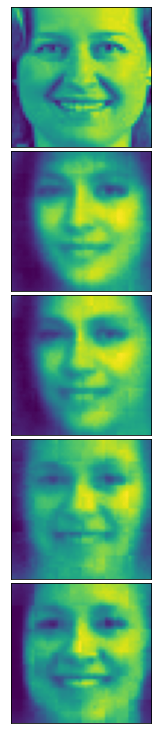

In [ ]:
with torch.no_grad():
    for i, (x, _) in enumerate(validation_loader):
        x = x.float().to(device)

        fig,ax = plt.subplots(5,1,sharex=True, sharey=True, figsize=(2,10))

        ax[0].imshow(x[0,0].cpu().detach().numpy())
        ax[0].set_ylabel('Original')

        recon_x, _, _, _  = VAE_dim_4_no_beta(x)
        ax[1].imshow(recon_x[0,0].cpu().detach().numpy())
        ax[1].set_ylabel('Dim=4, Beta=1')

        recon_x, _, _, _  = VAE_dim_4_beta_001(x)
        ax[2].imshow(recon_x[0,0].cpu().detach().numpy())
        ax[2].set_ylabel('Dim=4, Beta=0.01')

        recon_x, _, _, _  = VAE_dim_256_no_beta(x)
        ax[3].imshow(recon_x[0,0].cpu().detach().numpy())
        ax[3].set_ylabel('Dim=256, Beta=1')

        recon_x, _, _, _  = VAE_dim_256_beta_001(x)
        ax[4].imshow(recon_x[0,0].cpu().detach().numpy())
        ax[4].set_ylabel('Dim=256, Beta=0.01')

        ax[0].yaxis.set_ticks_position('none') 
        ax[0].xaxis.set_ticks_position('none') 
        ax[0].set_yticks([])
        ax[0].set_xticks([])
        plt.tight_layout(pad=0)

        break




## (From Section 2.2.3) Image Restoration

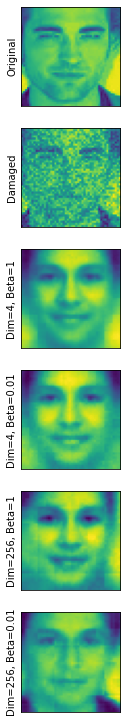

In [ ]:
with torch.no_grad():
    for i, (x, _) in enumerate(validation_loader):
        x = x.float().to(device)
        
        x_bad = copy.deepcopy(x) 

        x_bad = x_bad + torch.rand((10,1,48,48)).to(device)*100 # damage the data by Gaussian noise     

        fig,ax = plt.subplots(3,1,sharex=True, sharey=True, figsize=(2,10))

        ax[0].imshow(x[0,0].cpu().detach().numpy())
        ax[0].set_ylabel('Original')

        ax[1].imshow(x_bad[0,0].cpu().numpy())
        ax[1].set_ylabel('Damaged')

        recon_x, _, _, _  = VAE_dim_256_beta_001(x_bad)
        ax[2].imshow(recon_x[0,0].cpu().detach().numpy())
        ax[2].set_ylabel('Dim=256, Beta=0.01')

        ax[0].yaxis.set_ticks_position('none') 
        ax[0].xaxis.set_ticks_position('none') 
        ax[0].set_yticks([])
        ax[0].set_xticks([])
        plt.tight_layout(pad=0)

        break




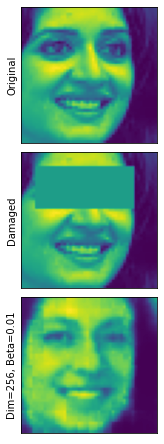

In [ ]:
with torch.no_grad():
    for i, (_, _) in enumerate(validation_loader):
        # x = x.float().to(device)
        
        x_bad = copy.deepcopy(x) 
        x_bad[0,0,5:20,5:40]=120 # data deletion

        fig,ax = plt.subplots(3,1,sharex=True, sharey=True, figsize=(2,6))

        ax[0].imshow(x[0,0].cpu().detach().numpy())
        ax[0].set_ylabel('Original')

        ax[1].imshow(x_bad[0,0].cpu().numpy())
        ax[1].set_ylabel('Damaged')

        recon_x, _, _, _  = VAE_model(x_bad)
        ax[2].imshow(recon_x[0,0].cpu().detach().numpy())
        ax[2].set_ylabel('Dim=256, Beta=0.01')

        ax[0].yaxis.set_ticks_position('none') 
        ax[0].xaxis.set_ticks_position('none') 
        ax[0].set_yticks([])
        ax[0].set_xticks([])
        plt.tight_layout(pad=0)
        
        break

## (From Section 2.2.4) Interpolation

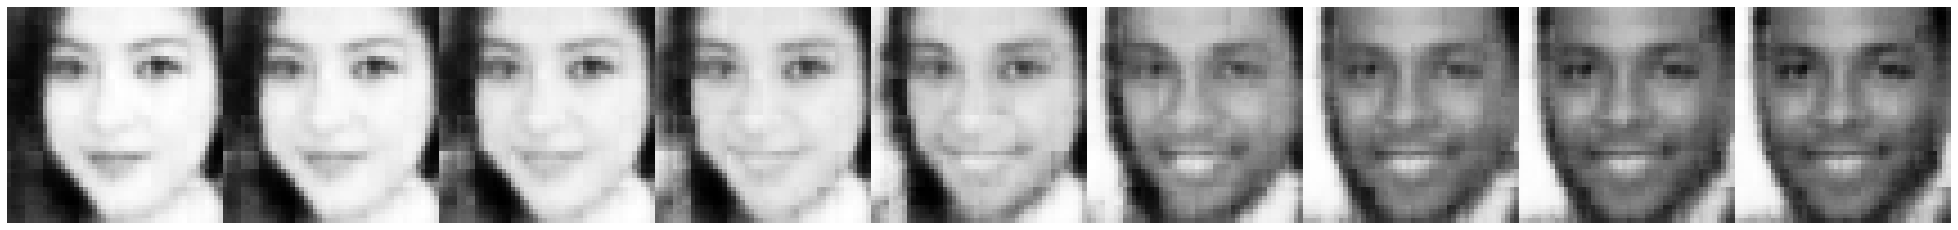

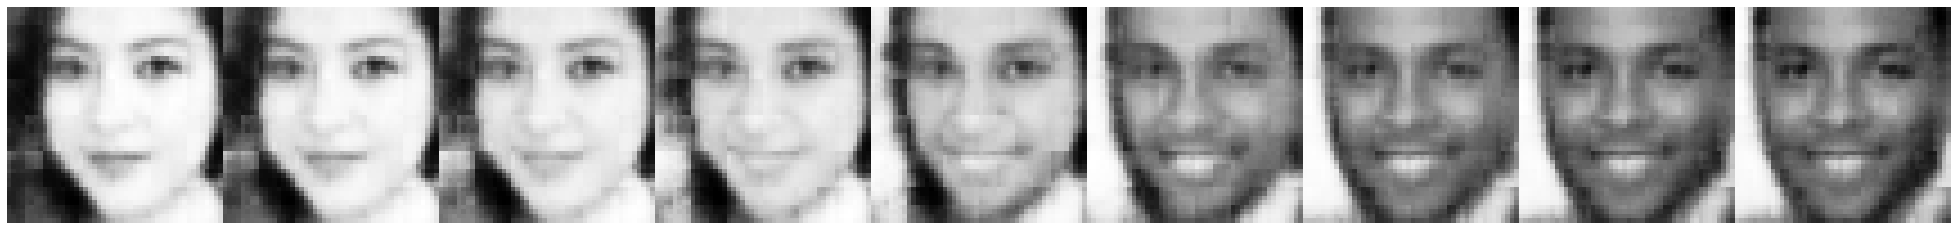

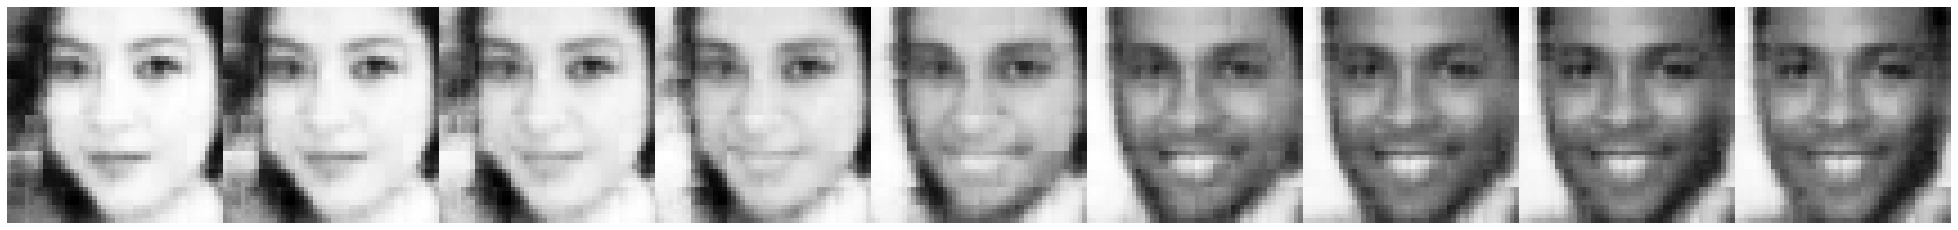

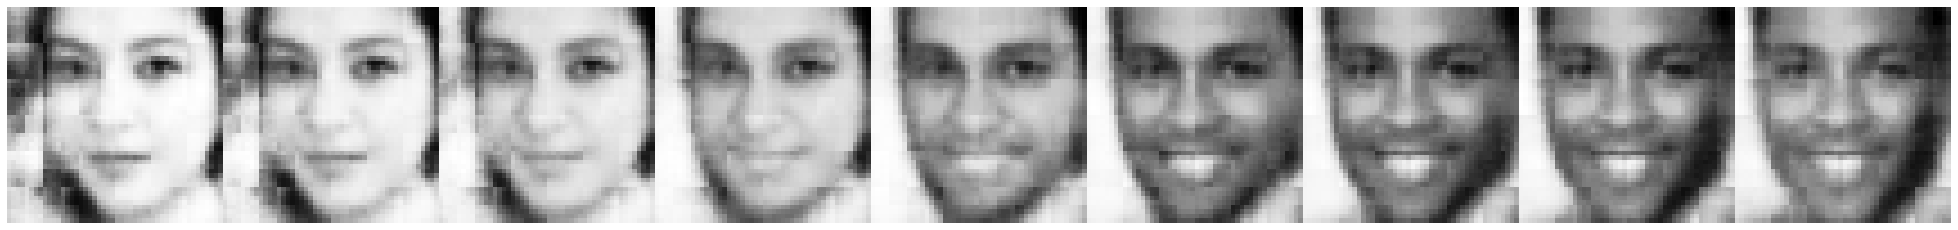

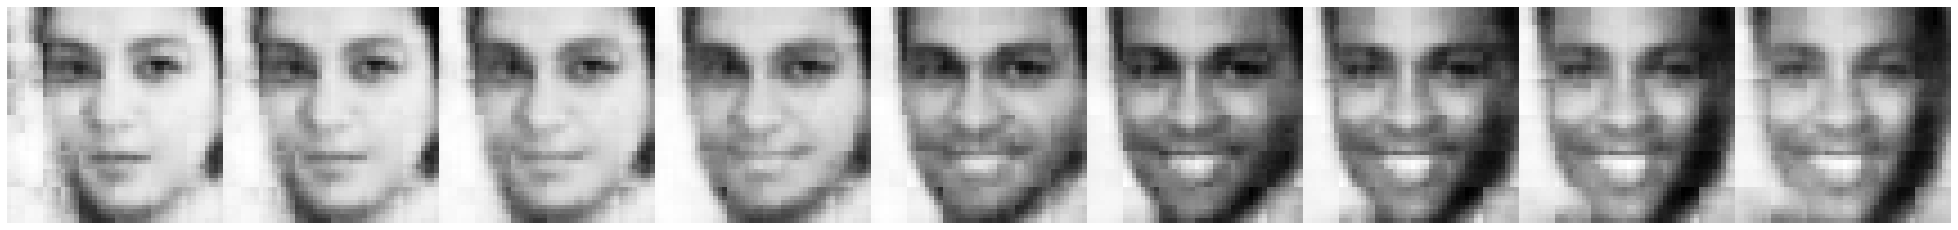

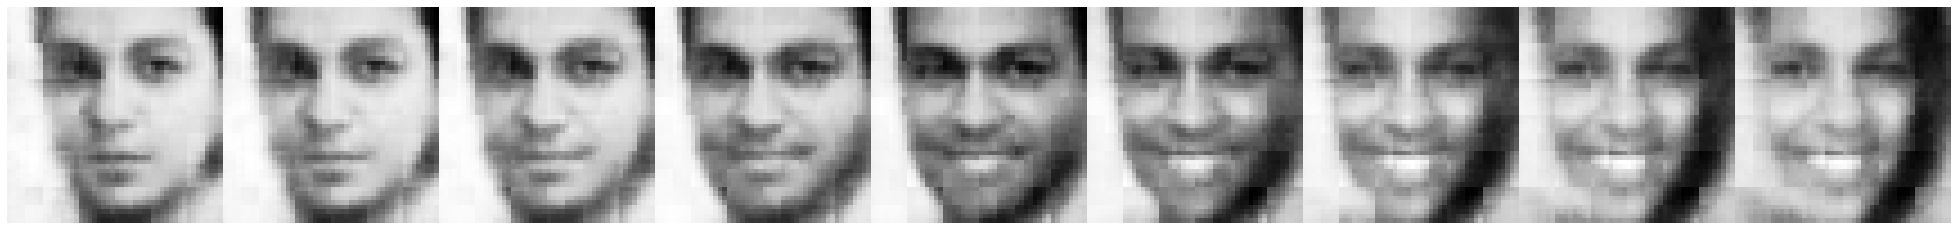

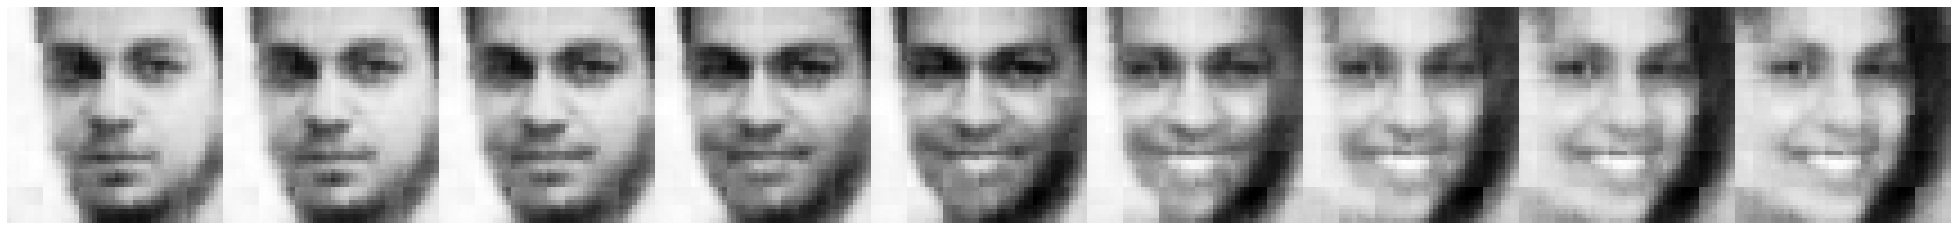

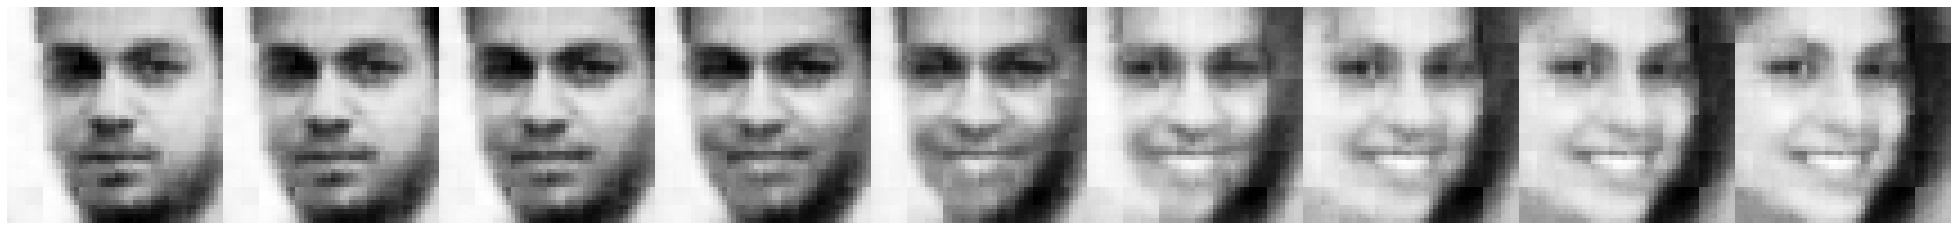

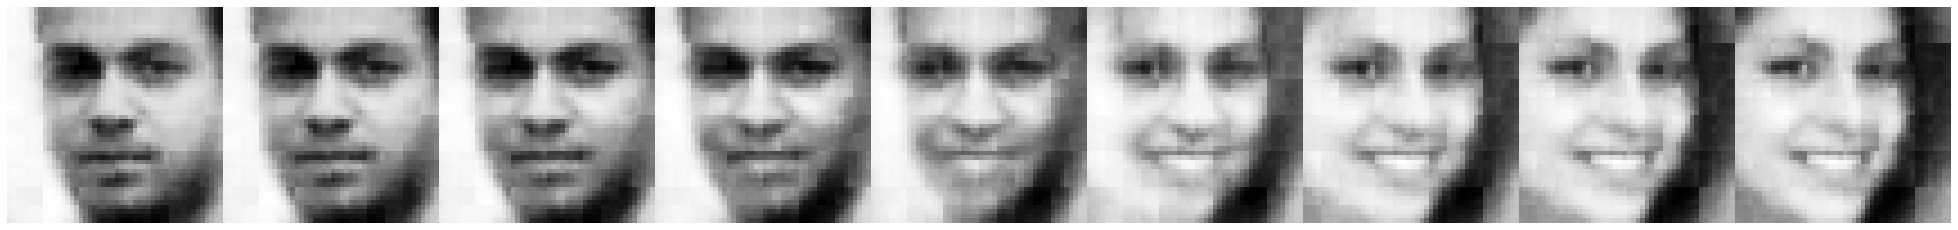

In [ ]:
# sample z1, z2, z3, z4, from the learned latent distribution to run this

checkpoints = [0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1]
interpolated_latent_vectors_LHS = [lam * z3 + (1-lam) * z2 for lam in checkpoints]
interpolated_latent_vectors_RHS = [lam * z4 + (1-lam) * z1 for lam in checkpoints]

for LHS,RHS in zip(interpolated_latent_vectors_LHS, interpolated_latent_vectors_RHS):
    interpolated_row = [lam * LHS + (1-lam) * RHS for lam in checkpoints]

    fig, ax = plt.subplots(1, len(checkpoints), figsize=(27,3), sharey=True, sharex=True)
    for col,img in enumerate(interpolated_row):
        ax[col].axis('off')
        ax[col].imshow(VAE_model.decoder(img)[0,0].cpu().detach().numpy(), cmap="Greys_r")

    fig.tight_layout(pad=0, h_pad=0)